In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.animation as animation
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame
import pickle
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')


%matplotlib widget

In [2]:
def load_files(files):
    s21s = []
    for i, file in enumerate(files):
        freqs, s21 = np.load(file)
        s21s.append(s21)
    return freqs, np.array(s21s)

def track_tones(s21, locs, limit=5):
    for i, loc in enumerate(locs):
        init_loc = copy(loc)
        prev = s21[loc-1]
        now = s21[loc]
        next = s21[loc+1]
        if next < now:
            while next < now:
                loc += 1
                prev = now
                now = next
                next = s21[loc+1]
        elif next > now:
            while prev < now:
                loc -= 1
                next = now
                now = prev
                prev = s21[loc-1]
        elif next >= now and prev <= now:
            print('At min: ', i)
        else:
            print('No min: ', i)
        if abs(loc - init_loc) <= limit:
            locs[i] = loc
        else:
            print('Too far: ', i)   
    _, unique_indices = np.unique(locs, return_index=True)
    unique_mask = np.zeros(locs.shape, dtype=bool)
    unique_mask[unique_indices] = True
    return locs, unique_mask

def smooth_sweep(s21, sw, order):
    smooth_s21 = savgol_filter(s21, sw, order)
    return smooth_s21

def readout_tones(tones, s21s, dark, smoothing_window, smoothing_order):
    s21_mins = dark[tones]
    nr_kids = len(tones)
    nr_scans = s21s.shape[0]
    ds21s = np.empty((nr_scans, nr_kids))
    for i, s21 in enumerate(s21s):
        smooth_s21 = smooth_sweep(s21, smoothing_window, smoothing_order)
        ds21s[i, :]  = smooth_s21[tones] - s21_mins
    return ds21s

def get_pos(ds21s, mpp):
    nr_kids = ds21s.shape[1]
    pos = np.empty((nr_kids)) # f0, 
    pos[:] = np.nan
    maxproms = np.empty((nr_kids)) # f0, 
    maxproms[:] = np.nan
    secproms = np.empty((nr_kids)) # f0, 
    secproms[:] = np.nan
    doubles = []
    for i in range(nr_kids):
        ds21 = ds21s[:, i]
        y = medfilt(ds21, 3)
        x = np.arange(len(y))
        a, b = np.polyfit(x, y, 1)
        ds21 -= (a*x + b)
        ds21s[:, i] = ds21
        baseline = y - (a*x + b)
        argsort = np.argsort(ds21)
        argmax = argsort[-1]
        secargmax = argsort[-2]
        max = ds21[argmax]
        secmax = ds21[secargmax]
        mean = np.mean(baseline)
        maxprom = max - mean
        secprom =  secmax - mean
        pos[i] = argmax
        maxproms[i] = maxprom
        secproms[i] = secprom
        if secprom >= mpp: 
            if len(doubles):
                if doubles[-1] != i-1:
                    doubles.append(i)
                else:
                    doubles = doubles[:-1]
            else:
                doubles.append(i)
    print('Mean prominence: ', np.mean(maxproms))
    fig, ax = plt.subplot_mosaic('ab', figsize=(4,2))
    hist = ax['a'].hist(pos, bins=np.arange(ds21s.shape[0]+1), facecolor='tab:blue', edgecolor='w')
    ax['b'].axvline(mpp, c='r')
    # ax['a'].axhline(nr_rows, c='r')
    ax['b'].hist(maxproms, bins='auto')
    ax['b'].hist(secproms, bins='auto')
    print('total: ', np.sum(~np.isnan(pos)))
    print('nr doubles: ', len(doubles))
    print(doubles)
    return pos, maxproms, secproms, doubles

def add_kids(added, to_add):
    global rows, cols, maxproms, secproms, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    added = np.array(added, dtype=int)
    to_add = np.array(to_add, dtype=int)
    secargmax_rows = np.argsort(ds21s_rows[:, to_add], axis=0)[-2, :]
    rows = np.insert(rows, to_add, secargmax_rows)
    ds21s_rows = np.insert(ds21s_rows, to_add, ds21s_rows[:, to_add], axis=1)
    secargmax_cols = np.argsort(ds21s_cols[:, to_add], axis=0)[-2, :]
    cols = np.insert(cols, to_add, secargmax_cols)
    ds21s_cols = np.insert(ds21s_cols, to_add, ds21s_cols[:, to_add], axis=1)
    maxproms = np.insert(maxproms, to_add, secproms[to_add])
    secproms = np.insert(secproms, to_add, maxproms[to_add])
    f0s = np.insert(f0s, to_add, f0s[to_add])
    locs = np.insert(locs, to_add, locs[to_add])
    to_add = np.sort(to_add)
    to_add += np.arange(len(to_add))
    for kid in to_add:
        added[added >= kid] += 1
        added = np.hstack((added, kid, kid+1))
    return list(np.sort(added))

def del_kids(added, to_delete):
    global rows, cols, maxproms, secproms, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    to_delete = np.sort(to_delete)
    to_delete = np.array(to_delete, dtype=int)
    added = np.array(added, dtype=int)
    
    rows = np.delete(rows, to_delete)
    cols = np.delete(cols, to_delete)
    maxproms = np.delete(maxproms, to_delete)
    secproms = np.delete(secproms, to_delete)
    f0s = np.delete(f0s, to_delete)
    ds21s_rows = np.delete(ds21s_rows, to_delete, axis=1)
    ds21s_cols = np.delete(ds21s_cols, to_delete, axis=1)
    locs = np.delete(locs, to_delete)
    for kid in to_delete[::-1]:
        if kid in added:
            added = np.delete(added, np.argwhere(added == kid))
        if kid-1 in added: 
            added = np.delete(added, np.argwhere(added == kid-1))
        elif kid+1 in added: 
            added = np.delete(added, np.argwhere(added == kid+1))
        added[added >= kid] -= 1
    return list(added)

def plot_dipshit(s21s, ds21s, pos, kids, steps=[], bw=50):
    global f0s, locs, freqs, avg_s21, smoothing_window, smoothing_order
    fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
    custom_colors = ['b', 'y', 'g', 'p']

    for kid in kids:
        ds21 = ds21s[:, kid]
        baseline = medfilt(ds21, 3)
        res = f0s[kid]
        loc = locs[kid]
        index = np.arange(loc-bw,loc+bw)
        hit = int(pos[kid])
        ax['b'].axhline(np.mean(baseline), ls='--', lw=1, c='k')
        ax['a'].plot(freqs[index], avg_s21[index], lw=2, label='dark', c='k')
        ax['a'].axvline(res, c='k', ls='--', lw=1)
        ax['a'].plot(freqs[index], smooth_sweep(s21s[hit, index], smoothing_window, smoothing_order), lw=2, label='hit @' + str(hit), c='r')
        ax['b'].axvline(hit, ls='--', lw=2, c='r')
        for i, step in enumerate(steps):
            ax['a'].plot(freqs[index], smooth_sweep(s21s[step, index], smoothing_window, smoothing_order), lw=1, label=str(step), c=custom_colors[i])
            ax['b'].axvline(step, ls='--', lw=1, c=custom_colors[i])
        ax['b'].plot(ds21, lw=2, label=str(kid), c='k')
    ax['b'].legend()
    ax['a'].legend()

def plot_rows(rows, doubles=[], lo=None):    
    global f0s, nr_cols
    fig, ax = plt.subplot_mosaic('aaaab', figsize=(14,9), constrained_layout=True, sharey=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(f0s, rows, c=maxproms, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='vertical', location='left')
    cbar.set_label('Max Prominence')
    for id, row in enumerate(rows):
        ax['a'].annotate(id, (f0s[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(f0s[id], rows[id], marker='o', facecolor='None', edgecolor='k', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_yticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axvline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', orientation='horizontal', label=['< LO', '> LO'], stacked=True)
        ax['b'].axvline(nr_cols/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w', orientation='horizontal')
    ax['b'].axvline(nr_cols, c='k', ls='-', lw=2)
    ax['b'].legend()

def plot_cols(rows, doubles=[], lo=None):    
    global f0s, nr_rows
    fig, ax = plt.subplot_mosaic('b;a;a;a;a', figsize=(9,14), constrained_layout=True, sharex=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(rows, f0s, c=maxproms, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='horizontal', location='bottom')
    cbar.set_label('Max Prominence')
    for id, col in enumerate(rows):
        ax['a'].annotate(id, (col+.3, f0s[id]), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(rows[id], f0s[id], marker='o', facecolor='None', edgecolor='k', linewidth=2)
        ax['a'].scatter(rows[id+1], f0s[id+1], marker='o', facecolor='None', edgecolor='k', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_xticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axhline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', label=['< LO', '> LO'], stacked=True)
        ax['b'].axhline(nr_rows/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w')
    ax['b'].axhline(nr_rows, c='k', ls='-', lw=2)
    ax['b'].legend()

def map_kids(nans, roll):
    global rows, nr_rows, nr_cols
    row_list = [[] for _ in range(nr_rows)]
    for id, row in enumerate(rows):
        if not np.isnan(row):
            row_list[int(row)].append(int(id))
    map_sorted = np.empty((nr_rows, nr_cols))
    map_sorted[:] = np.nan   
    for i, row in enumerate(row_list):
        map_sorted[i, :len(row)] = row
    for i, j in nans:
        map_sorted[i, j+1:] = map_sorted[i, j:-1]
        map_sorted[i, j] = np.nan
    map = copy(map_sorted)
    for i, row in enumerate(map_sorted):
        map[i] = np.roll(row, i*roll)
    fig, ax = plt.subplot_mosaic('ab', figsize=(5,3), constrained_layout=True)
    ax['a'].imshow(map_sorted, cmap='viridis', origin='lower')
    ax['b'].imshow(map, cmap='viridis', origin='lower')
    return map

def common_mode(x, y, deg):
    coeff = np.polyfit(x, y, deg)
    cmode = np.poly1d(coeff)
    print(cmode)
    return cmode

def comp_scatter(design, meas, deg): 
    nanmask = np.isnan(meas) + np.isnan(design) 
    cmode = common_mode(design[~nanmask], meas[~nanmask], deg)
    design_fit = cmode(design)
    scatter = (meas - design_fit) / design_fit
    return scatter, cmode

def plot_scatter(deg=1, annotate=False, clim=[]):
    global design, meas, nanmask, kid_id_board, nr_rows, nr_cols, kids

    df_f, cmode = comp_scatter(design, meas, deg)
    df_f_map = df_f[kid_id_board]
    flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])
    xfit = np.linspace(flim[0], flim[1])
    yfit = cmode(xfit)

    fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
    ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
    ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{meas}$')
    ax['a'].plot(xfit, yfit, c='k', label='common mode, deg=%d' % (len(cmode.c)-1), ls='--', lw=0.5)
    ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
    ax['a'].set_xlim(flim)
    ax['a'].set_ylim(flim)
    ax['a'].legend(loc='upper left')
    if not len(clim):
        clim = [np.amin(df_f[~nanmask]), np.amax(df_f[~nanmask])]
    ax['b'].scatter(design, df_f, c=df_f, vmin=clim[0], vmax=clim[1], label='residual')
    ax['b'].annotate
    ax['b'].set_ylabel('$\it df*/f$')
    ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
    if annotate:
        for i, x in enumerate(df_f_map):
            for j, y in enumerate(x):
                if ~np.isnan(y):
                    old_id = kid_id_board[i, j]
                    new_id = kids[i, j]
                    if old_id == new_id:
                        c = 'w'
                    else:
                        c = 'r'
                    ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=6, color='w', rotation=45)
    # Major ticks
    ax['c'].set_xticks(np.arange(0, nr_cols, 1)-0.5, minor=False)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1)-0.5, minor=False)
    ax['c'].set_xticks(np.arange(0, nr_cols, 1), minor=True)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1), minor=True)
    # Labels for major ticks
    ax['c'].set_xticklabels(np.arange(0, nr_cols, 1), minor=True, rotation=-90)
    ax['c'].set_yticklabels(np.arange(0, nr_rows, 1), minor=True, rotation=0)
    ax['c'].set_yticklabels([], minor=False)
    ax['c'].set_xticklabels([], minor=False)
    ax['c'].grid(which='major', linestyle='-', linewidth=0.5)
    ax['c'].grid(which='minor', visible=False)
    ax['c'].set_xlabel('$\it x$ $[px]$')
    ax['c'].set_ylabel('$\it y$ $[px]$')
    cbar = fig.colorbar(im, ax=ax['c'])
    _ = cbar.ax.set_ylabel('$\it df*/f$')

    scatter = np.std(df_f[~nanmask])
    pxl_yield = (np.sum(~np.isnan(meas))/(nr_rows*nr_cols))
    print('scatter = %.3f%%' % (scatter*1e2))
    print('yield = %.3f%%' % (pxl_yield*1e2))
    return df_f, df_f_map

def image(ds21s):
    global nr_rows, nr_cols

    nr_scans = ds21s.shape[0]
    maps = np.zeros((nr_rows, nr_cols, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    ds21s[:, k] -= np.amin(ds21s[:, k])
                    ds21s[:, k] /= np.amax(ds21s[:, k])
                    maps[i, j, nr] = ds21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan
    return maps

def plot_image(map, annotate=True):
    global kids
    
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.imshow(map, origin='lower', cmap='viridis')
    M, N = map.shape
    for i, x in enumerate(kids):
        for j, y in enumerate(x):
                if ~np.isnan(y):
                    new_id = kids[i, j]
                    ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
    # Major ticks
    ax.set_xticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_yticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_xticks(np.arange(0, M, 1), minor=True)
    ax.set_yticks(np.arange(0, M, 1), minor=True)
    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, N, 1), minor=True, rotation=0)
    ax.set_yticklabels(np.arange(0, M, 1), minor=True, rotation=0)
    ax.set_yticklabels([], minor=False)
    ax.set_xticklabels([], minor=False)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', visible=False)
    return fig, cax

def animate_image(maps, annotate=False, save=None):
    fig, cax = plot_image(maps[:,:, 0], annotate=annotate)
    nr_scans = maps.shape[2]
    def update(frame):
        cax.set_array(maps[:, :, frame])
        return cax,
    ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
    if save:
        ani.save(save, writer='Pillow')
    return ani

def rel_freqs(f0, f1, nr_kids):
    oct = np.log2(f1/f0)
    spacing = 2**(oct/(nr_kids-1))
    powers = np.arange(nr_kids)
    f0s = f0 * (spacing)**powers
    return f0s

In [4]:
dir  = r"C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\sonnet\LT402 Design/"
chip = 'LT402_20x20_5-7GHz'
path = dir + chip + '/'
with open('../LT402chip1/LT402chip1_master.pkl', 'rb') as f:
    master = pickle.load(f)

kid_id_board = np.load( path + chip + '_id.npy')

dir = '.\S21s_20251120_12h08/'
yfiles = natsorted(glob(dir + '*y*.npy'))[::-1]
xfiles = natsorted(glob(dir + '*x*.npy'))
freqs, s21s_rows = load_files(yfiles)
s21s_cols = load_files(xfiles)[1]
avg_s21 = np.mean(s21s_rows, axis=0)
_, dark_s21 = np.load(natsorted(glob(dir + '*dark*.npy'))[0])

nr_rows = 20
nr_cols = 20
nr = nr_rows * nr_cols

Total:  397
Too close, within 0.1 MHz:  0 , ids:  []
Overlapping:  0 , ids:  []


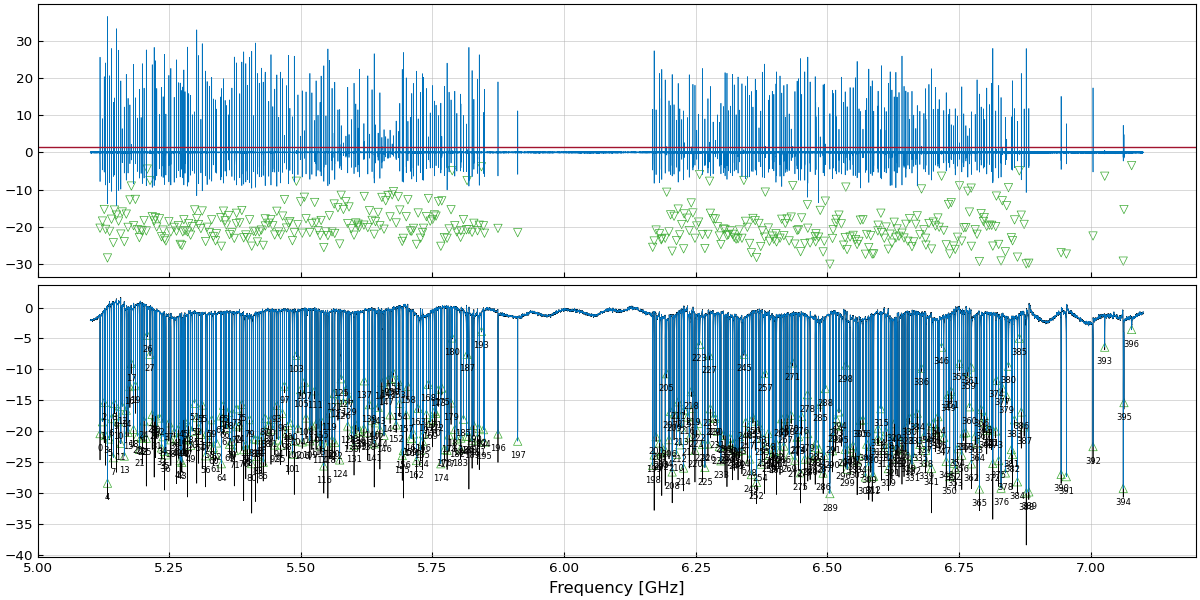

In [132]:
mph = 1.5
min_df = .1
smoothing_window = 3
smoothing_order = 0
smooth_avg_s21 = smooth_sweep(dark_s21, smoothing_window, smoothing_order)
d2s21 = np.diff(dark_s21, 2)

init_locs, props = find_peaks(-avg_s21, height=mph, prominence=mph)
init_locs = np.delete(init_locs, 390)
heights = avg_s21[init_locs]

init_locs, unique_mask = track_tones(avg_s21, init_locs)
# unique_mask[414] = 0

init_f0s = freqs[init_locs]
s21_mins = avg_s21[init_locs]

# BEGIN:
too_close_mask = np.zeros(init_f0s.shape, dtype=bool)
for i in range(len(init_f0s) - 1):
    if np.abs(init_f0s[i] - init_f0s[i + 1]) < min_df*1e-3 and (unique_mask[i] and unique_mask[i + 1]):
        if s21_mins[i] < s21_mins[i + 1]:
            too_close_mask[i + 1] = True
        else:
            too_close_mask[i] = True

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[2:], d2s21, lw=.5)
ax['b'].plot(freqs, dark_s21, lw=.5, c='k')
ax['b'].plot(freqs, avg_s21, lw=.5)
ax['a'].axhline(mph, c='r')
mask = ~too_close_mask & unique_mask
ax['a'].scatter(freqs[init_locs[mask]], heights[mask], marker='v', c='None', edgecolor='g')
ax['b'].scatter(init_f0s[mask], s21_mins[mask], marker='^', c='None', edgecolor='g')
ax['a'].scatter(freqs[init_locs[too_close_mask]], heights[too_close_mask], marker='v', c='None', edgecolor='p')
ax['b'].scatter(init_f0s[too_close_mask], s21_mins[too_close_mask], marker='^', c='None', edgecolor='p')
ax['a'].scatter(freqs[init_locs[~unique_mask]], heights[~unique_mask], marker='v', c='None', edgecolor='r')
ax['b'].scatter(init_f0s[~unique_mask], s21_mins[~unique_mask], marker='^', c='None', edgecolor='r')
for i, loc in enumerate(init_locs):
    ax['b'].annotate(f'{i}', (init_f0s[i], s21_mins[i]-5), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
ax['b'].set_xlabel('Frequency [GHz]')
print('Total: ', len(init_locs))
print('Too close, within', min_df, 'MHz: ', len(init_locs[too_close_mask]), ', ids: ', np.arange(len(init_locs))[too_close_mask])
print('Overlapping: ', len(init_locs[~unique_mask]), ', ids: ', np.arange(len(init_locs))[~unique_mask])

Mean prominence:  10.098575072023795
total:  397
nr doubles:  4
[4, 144, 243, 353]
Mean prominence:  9.812819290235414
total:  397
nr doubles:  4
[243, 284, 344, 365]
[243, 244]


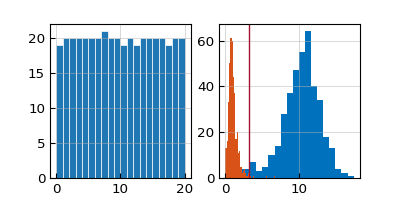

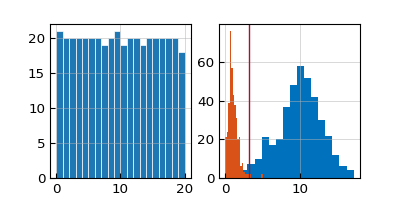

In [133]:
mask = unique_mask
locs = init_locs[mask]
f0s = init_f0s[mask]

ds21s_rows = readout_tones(locs, s21s_rows, avg_s21, smoothing_window, smoothing_order)
ds21s_cols = readout_tones(locs, s21s_cols, avg_s21, smoothing_window, smoothing_order)

mpp = 3.25
rows, maxproms, secproms, doubles = get_pos(ds21s_rows, mpp)
cols, _, _, xdoubles = get_pos(ds21s_cols, mpp)


doubles = add_kids([], doubles)
delete = [4, 145, 400]
doubles = del_kids(doubles, delete)
delete = [396]
doubles = del_kids(doubles, delete)
delete = [354]
doubles = del_kids(doubles, delete)
print(doubles)

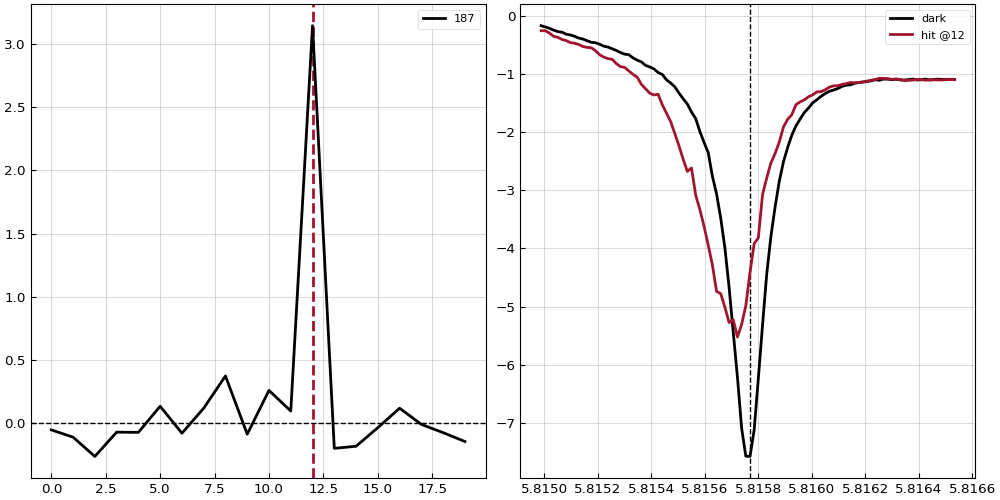

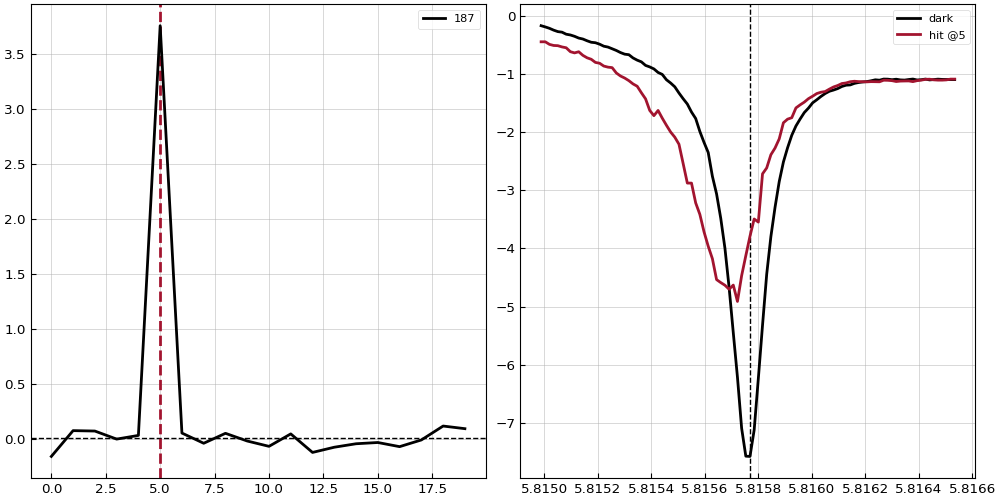

In [158]:
kids = [187]
steps = []
plot_dipshit(s21s_rows, ds21s_rows, rows, kids, steps)
plot_dipshit(s21s_cols, ds21s_cols, cols, kids, steps)

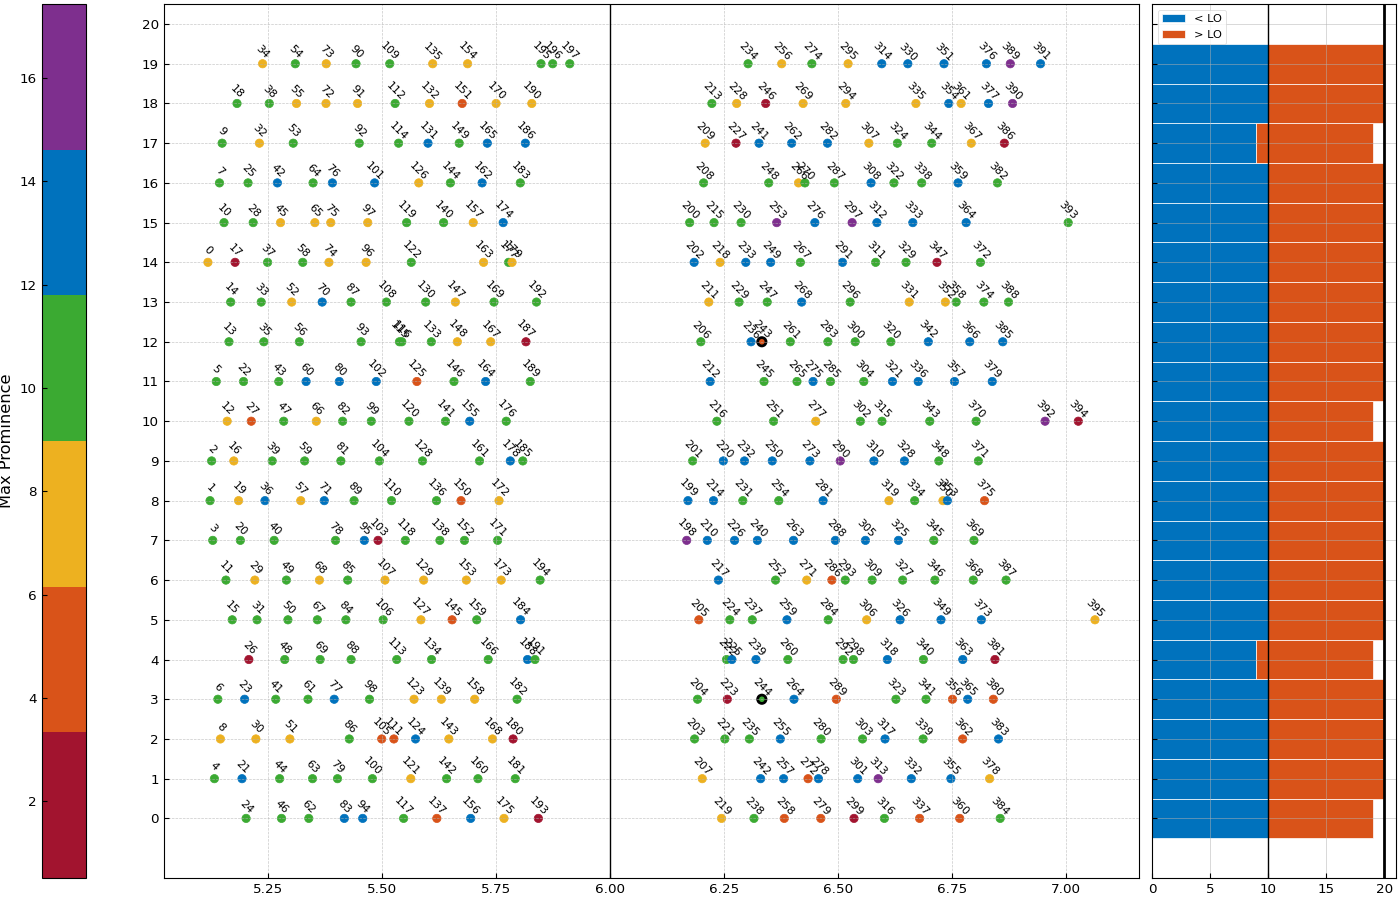

In [95]:
plot_rows(rows, doubles, lo=6)

In [ ]:
plot_cols(cols, doubles, lo=6)

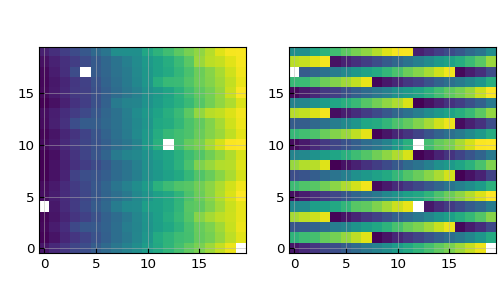

In [151]:
nans = [[0,19], [4, 0], [10,12], [17,4]]

kids = map_kids(nans, 8)

In [152]:
swaps = [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
[a, b] = [0, -1]
for row in swaps:
    kids[row, a], kids[row, b] = kids[row, b], kids[row, a]
swaps = [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 16, 18]
[a, b] = [1, -1]
for row in swaps:
    kids[row, a], kids[row, b] = kids[row, b], kids[row, a]

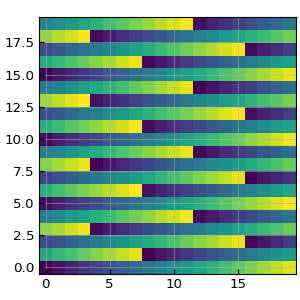

In [153]:
finger_lengths = master['trimdesign']['fingers']
design_f0s = master['trimdesign']['f0']
# coupler_lengths = master['trimdesign']['couplers']
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kid_id_board, cmap='viridis', origin='lower')

other :  24 24 279 0 0


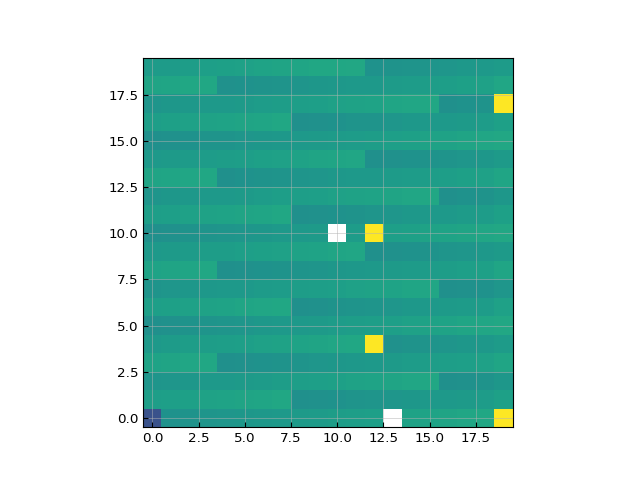

In [154]:
kids2 = np.empty((nr_rows, nr_cols))
kids2[:] = np.nan
for i in range(len(rows)):
    row = int(rows[i])
    col = int(cols[i])
    kid = kids2[row, col]
    if np.isnan(kid):
        kids2[row, col] = i
    else:
        if i in doubles:
            print('double: ', int(kids[row, col]), int(kids2[row, col]), i, row, col)
            kids2[row, col] = -2000
        else:
            if int(kids2[row, col]) in doubles:
                print('still double : ', int(kids[row, col]), int(kids2[row, col]), i, row, col)
                kids2[row, col] = -2000
            else:
                print('other : ', int(kids[row, col]), int(kids2[row, col]), i, row, col)
                kids2[row, col] = -1000

kids2[np.isnan(kids)] = 2000
fig, ax = plt.subplots()
ax.imshow(kids2, cmap='viridis', origin='lower', vmin=-2000, vmax=2000)


Text(0.5, 1.0, 'corrected map')

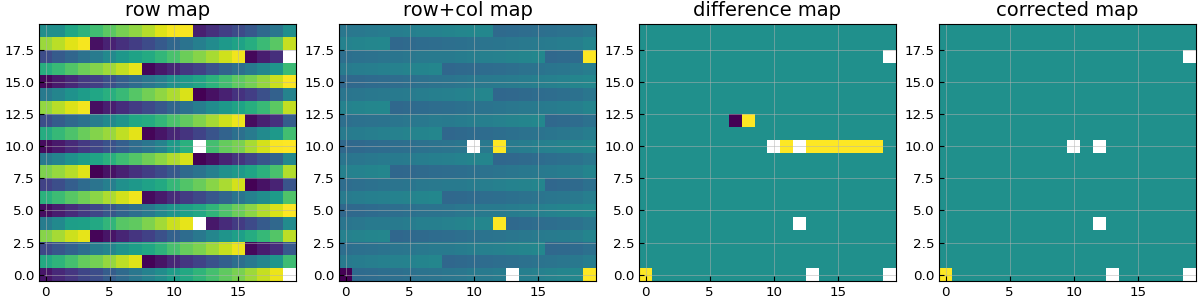

In [155]:
fig, ax = plt.subplot_mosaic('abcd', figsize=(12,3), constrained_layout=True)
diff_kids = kids-kids2
ax['a'].imshow(kids, cmap='viridis', origin='lower')
ax['a'].set_title('row map')
ax['b'].imshow(kids2, cmap='viridis', origin='lower')
ax['b'].set_title('row+col map')
ax['c'].imshow(diff_kids, cmap='viridis', origin='lower', vmin=-1, vmax=1)
ax['c'].set_title('difference map')

kids[12,7], kids[12, 8] = kids[12, 8], kids[12, 7]
kids[10,10:] = kids2[10,10:]
kids[10,12] = np.nan
# swaps = [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
# [a, b] = [0, -1]
# for row in swaps:
#     kids[row, a], kids[row, b] = kids[row, b], kids[row, a]
# swaps = [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 16, 18]
# [a, b] = [1, -1]
# for row in swaps:
#     kids[row, a], kids[row, b] = kids[row, b], kids[row, a]


diff_kids = kids-kids2
ax['d'].imshow(diff_kids, cmap='viridis', origin='lower', vmin=-1, vmax=1)
ax['d'].set_title('corrected map')


In [156]:
master['trimmeasured'] = {}
master['trimmeasured']['f0'] = np.empty(nr_rows*nr_cols)
master['trimmeasured']['f0'][:] = np.nan
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master['trimmeasured']['f0'][idx] = meas_f
design = master['trimdesign']['f0']
meas = master['trimmeasured']['f0']
nanmask = np.isnan(meas) + np.isnan(design)
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)



 
0.9982 x + 0.002522


TypeError: list indices must be integers or slices, not tuple

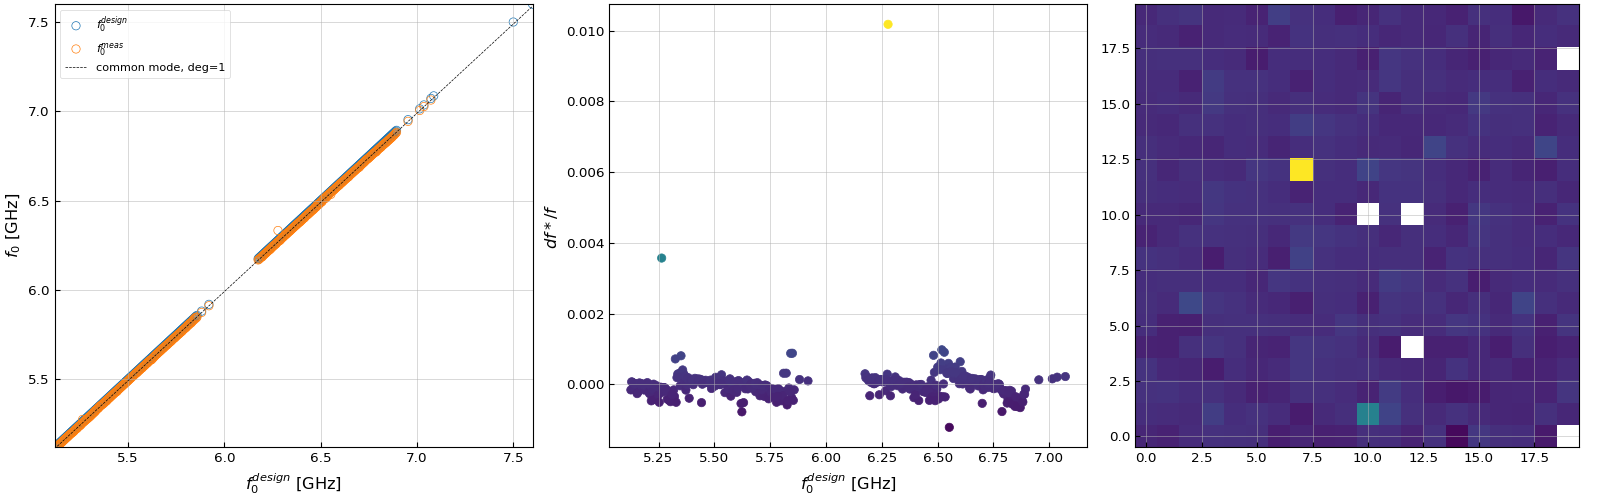

In [159]:
df_f, df_f_map = plot_scatter(1, annotate=True, clim=[-.0015, .01])

In [61]:
np.nanstd(df_f[np.abs(df_f) < .001])

0.0003412363891751492

In [16]:
# master['trimdesign'] = master['trimdesign']
# del master['trimdesign']
# with open('../Masters/LT402chip6_master.pkl', 'wb') as f:
#     pickle.dump(master, f)

[970. 874. 778. 682. 586. 490. 394. 298. 202. 106.  10.]
[12, 12, 12]
[137.26086934 137.26086934 137.26086934]


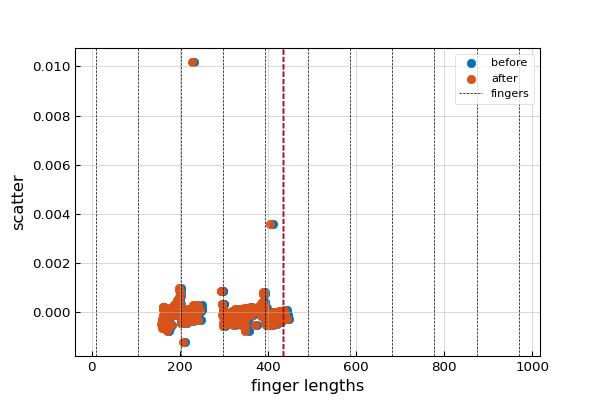

In [160]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(master['design']['fingers'], df_f)
ax.scatter(master['trimdesign']['fingers'], df_f)
ax.set_ylabel('scatter')
ax.set_xlabel('finger lengths')
fingers = np.linspace(10*1, 10*97, 11, endpoint=True)[::-1]
fingers_idx = []
trim_fingers = master['trimdesign']['fingers']
for finger in fingers:
    smaller = np.argwhere(trim_fingers <= finger)
    if len(smaller) and len(smaller)!=np.sum(~np.isnan(trim_fingers)):	
        fingers_idx.append(int(smaller[0][0]))
    else:
        pass
    ax.axvline(finger, ls='--', lw=0.5, c='k')
print(fingers)
print(fingers_idx)
print(trim_fingers[fingers_idx])
for id in fingers_idx:
    ax.axvline(trim_fingers[id-1], ls='--', lw=1, c='r')
ax.legend(['before', 'after', 'fingers'])

         2
0.01375 x + 0.8827 x + 0.2023
scatter = 0.832%
yield = 99.500%
           2
-0.001686 x + 1.018 x - 0.05795
scatter = 0.060%
yield = 98.750%


Text(0.5, 1.0, 'After, yield = 94.3%')

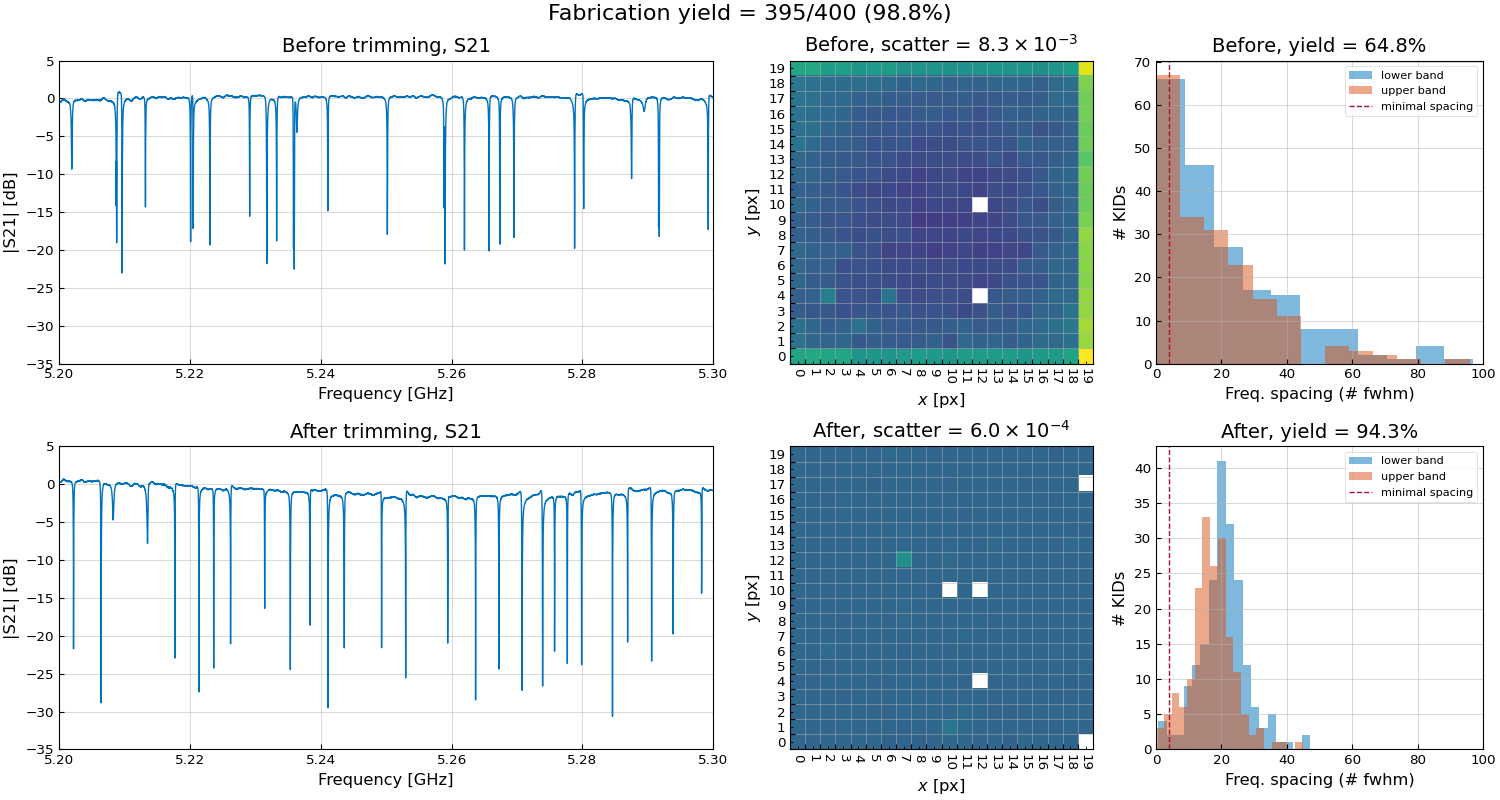

In [162]:
def plot_spacings(f0s, Q, threshold, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    diffs = np.diff(f0s)
    fwhms = f0s/ Q
    rel_diffs = diffs/fwhms[:-1]
    lo_id = np.argmax(diffs)
    _ = ax.hist(rel_diffs[:lo_id], bins='auto', alpha=.5, label='lower band')
    _ = ax.hist(rel_diffs[lo_id+1:], bins='auto', alpha=.5, label='upper band')
    ax.axvline(threshold, c='r', ls='--', lw=1, label='minimal spacing')
    ax.set_xlabel('Freq. spacing (# fwhm)')
    ax.set_ylabel('# KIDs')
    ax.legend()
    too_close = rel_diffs<threshold
    good = np.ones(f0s.shape)
    good[1:] -= too_close
    good[:-1] -= too_close
    spaced = np.sum(good==True)
    total = len(f0s)
    return spaced/total


def plot_scatter2(design, meas, kid_id_board, deg=1, clim=[], ax=None):
    df_f, cmode = comp_scatter(design, meas, deg)
    df_f_map = df_f[kid_id_board]

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
    im = ax.imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
    # Major ticks
    ax.set_xticks(np.arange(0, nr_cols, 1)-0.5, minor=False)
    ax.set_yticks(np.arange(0, nr_rows, 1)-0.5, minor=False)
    ax.set_xticks(np.arange(0, nr_cols, 1), minor=True)
    ax.set_yticks(np.arange(0, nr_rows, 1), minor=True)
    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, nr_cols, 1), minor=True, rotation=-90)
    ax.set_yticklabels(np.arange(0, nr_rows, 1), minor=True, rotation=0)
    ax.set_yticklabels([], minor=False)
    ax.set_xticklabels([], minor=False)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', visible=False)
    ax.set_xlabel('$\it x$ $[px]$')
    ax.set_ylabel('$\it y$ $[px]$')
    # _ = cbar.ax.set_ylabel('$\it df*/f$')

    scatter = np.std(df_f[~nanmask])
    pxl_yield = (np.sum(~np.isnan(meas))/(nr_rows*nr_cols))
    print('scatter = %.3f%%' % (scatter*1e2))
    print('yield = %.3f%%' % (pxl_yield*1e2))
    return scatter


path_before ='../LT402chip1/S21s_20251031_12h07\S21_dark.npy'
path_after = 'VNAsweep.npy'
flim = [5.2, 5.3]
ylim = [-35, 5]
fig, axes = plt.subplot_mosaic('eeac;ffbd', figsize=(15,8), constrained_layout=True)
kids_found = np.sum(~np.isnan(meas))
fig.suptitle('Fabrication yield = %d/%d (%.1f%%)' % (kids_found, nr, kids_found/nr*1e2), fontsize=16)
ax = axes['e']
ax.plot(*np.load(path_before), lw=1, label='Before')
ax.set_xlim(flim)
ax.set_ylim(ylim)
ax.set_title('Before trimming, S21')
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('|S21| [dB]')
ax = axes['f']
ax.plot(freqs, dark_s21, lw=1, label='After')
ax.set_xlim(flim)
ax.set_ylim(ylim)
ax.set_title('After trimming, S21')
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('|S21| [dB]')
deg = 2
clim = [-0.02, 0.04]
ax = axes['a']
scatter = plot_scatter2(master['design']['f0'], master['measured']['f0'], kid_id_board, deg, clim, ax)
order = np.floor(np.log10(scatter))
ax.set_title('Before, scatter = $%.1f\\times10^{%d}$' % (scatter/10**order, order))
ax = axes['b']
scatter = plot_scatter2(master['trimdesign']['f0'], master['trimmeasured']['f0'], kid_id_board, deg, clim, ax)
order = np.floor(np.log10(scatter))
ax.set_title('After, scatter = $%.1f\\times10^{%d}$' % (scatter/10**order, order))
# cbar = fig.colorbar(im, axes['b'], orientation='horizontal', location='top')
# _ = cbar.ax.set_ylabel('$\it df*/f$')
ax = axes['c']
threshold = 4
Q = 30e3
xlim = [0, 100]
f0s_pretrim = master['measured']['f0']
f0s_pretrim = np.sort(f0s_pretrim[~np.isnan(f0s_pretrim)])
y = plot_spacings(f0s_pretrim, Q, threshold, ax)
ax.set_title('Before, yield = %.1f%%' % (y*1e2))
_ = ax.set_xlim(xlim)
ax = axes['d']
f0s = master['trimmeasured']['f0']
f0s = np.sort(f0s[~np.isnan(f0s)])[:-12]
y = plot_spacings(f0s, Q, threshold, ax)
_ = ax.set_xlim(xlim)
ax.set_title('After, yield = %.1f%%' % (y*1e2))

In [222]:
maps = image(ds21s_rows)

In [ ]:
_ = plot_image(maps[:,:, 0])

In [ ]:
anim = animate_image(maps)
plt.show()

In [101]:
# with open('LT402chip6_master.pkl', 'wb') as f:
#     pickle.dump(master, f)
    